# Comparison: SNMF-Krotov vs Direct Krotov

This notebook compares two approaches for storing and retrieving continuous patterns:

1. **SNMF + Krotov (Hierarchical)** - `TreeNetworkKrotovNoInit` from `krotov_hopfield_no_init.py`
   - Uses SNMF for hierarchical clustering
   - Patterns are routed through clusters before storage in Krotov-Hopfield
   - `max_patterns` = patterns per bottom cluster

2. **Direct Krotov (Flat)** - `DirectKrotovNetwork` from `krotov_direct.py`
   - No SNMF clustering
   - Patterns are directly stored in a single Krotov-Hopfield network
   - `max_patterns` >= total number of patterns

We will test both approaches on ultrametric continuous patterns and compare:
- Retrieval accuracy (MSE, correlation)
- Learning speed (how many epochs to converge)
- Noise robustness

In [15]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import both implementations
import krotov_hopfield_no_init as kh_snmf
import krotov_direct as kh_direct

## 1. Setup: Create Ultrametric Tree of Continuous Patterns

In [16]:
# Tree structure parameters
tree_struct_list = (3, 6, 120)  # 2 first-level clusters, 3 second-level, 60 patterns each
n_input_neurons = 500
base_norm = 1.0  # Norm at first level (halves each subsequent level)

# Total patterns
n_total_patterns = np.prod(tree_struct_list)
n_patterns_per_cluster = tree_struct_list[-1]  # Bottom level patterns per cluster

print(f"Tree structure: {tree_struct_list}")
print(f"Total patterns: {n_total_patterns}")
print(f"Patterns per bottom cluster: {n_patterns_per_cluster}")
print(f"Number of bottom clusters: {np.prod(tree_struct_list[:-1])}")

Tree structure: (3, 6, 120)
Total patterns: 2160
Patterns per bottom cluster: 120
Number of bottom clusters: 18


In [17]:
# Create the ultrametric tree of continuous patterns
key = jax.random.PRNGKey(42)
patterns_tree = kh_snmf.UltraMetricTreeContinuous(key, n_input_neurons, tree_struct_list, base_norm)
patterns_tree.construct_tree()

# Get all patterns as array
all_descendents = jnp.array(patterns_tree.descendents)[0]
print(f"Pattern tree shape: {all_descendents.shape}")

# Flatten patterns for training
all_patterns = np.array(all_descendents.reshape((-1, n_input_neurons)))
n_patterns = all_patterns.shape[0]
print(f"Flattened shape: {all_patterns.shape}")

Pattern tree shape: (3, 6, 120, 500)
Flattened shape: (2160, 500)


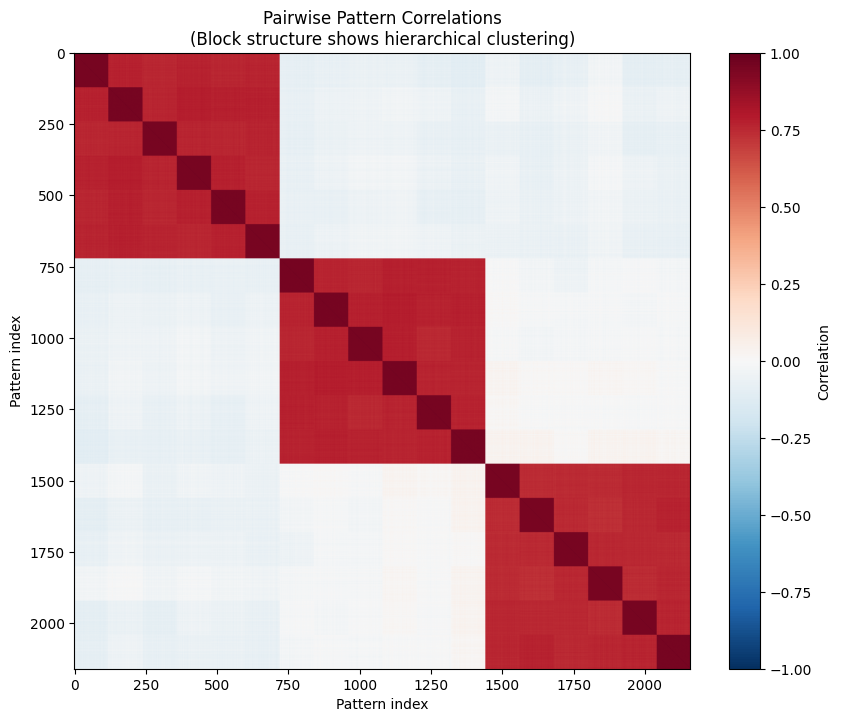

In [18]:
# Visualize pattern correlation structure
correlations = np.zeros((n_patterns, n_patterns))
for i in range(n_patterns):
    for j in range(n_patterns):
        correlations[i, j] = float(kh_snmf.compute_correlation(all_patterns[i], all_patterns[j]))

plt.figure(figsize=(10, 8))
plt.imshow(correlations, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Pairwise Pattern Correlations\n(Block structure shows hierarchical clustering)')
plt.xlabel('Pattern index')
plt.ylabel('Pattern index')
plt.show()

## 2. Create Networks

**Important capacity settings:**
- SNMF-Krotov: `max_patterns` = patterns per bottom cluster (60)
- Direct Krotov: `max_patterns` >= total patterns (360)

In [19]:
# Common parameters
beta = 5.0  # Inverse temperature for softmax
decay = 0.99  # Online learning decay

# SNMF-Krotov Network (hierarchical)
np.random.seed(123)
network_snmf = kh_snmf.TreeNetworkKrotovNoInit(
    n_input_neurons=n_input_neurons,
    tree_struct_list=tree_struct_list[:-1],  # (2, 3) - classification layers
    tree_decay1_list=(0.99, 0.99),
    tree_decay2_list=(0.99, 0.99),
    decay3=decay,
    beta=beta,
    max_patterns=n_patterns_per_cluster + 10  # Per cluster capacity (60 + buffer)
)

# Direct Krotov Network (flat, single associative memory)
np.random.seed(123)
network_direct = kh_direct.DirectKrotovNetwork(
    n_neurons=n_input_neurons,
    n_classes=1,  # Single associative memory (no clustering)
    beta=beta,
    decay=decay,
    max_patterns_per_class=n_total_patterns + 50  # Total capacity (360 + buffer)
)

print("SNMF-Krotov Network (hierarchical):")
print(f"  Structure: {tree_struct_list[:-1]}")
print(f"  Max patterns per cluster: {n_patterns_per_cluster + 10}")
print(f"  Number of clusters: {np.prod(tree_struct_list[:-1])}")
print()
print("Direct Krotov Network (flat):")
print(f"  Max patterns: {n_total_patterns + 50}")
print(f"  No clustering (single memory)")

SNMF-Krotov Network (hierarchical):
  Structure: (3, 6)
  Max patterns per cluster: 130
  Number of clusters: 18

Direct Krotov Network (flat):
  Max patterns: 2210
  No clustering (single memory)


## 3. Online Training with Periodic Evaluation

In [20]:
# Training parameters
n_epochs = 15000
test_spacing = 100
mse_tolerance = 0.01  # Threshold for retrieval failure

np.random.seed(0)

# Metrics storage
n_tests = int(n_epochs / test_spacing)
mse_snmf = np.zeros(n_tests)
mse_direct = np.zeros(n_tests)
corr_snmf = np.zeros(n_tests)
corr_direct = np.zeros(n_tests)
failures_snmf = np.zeros(n_tests)
failures_direct = np.zeros(n_tests)

# Pre-generate random indices for consistent training order
training_indices = np.random.randint(n_patterns, size=n_epochs)

pbar = tqdm(range(n_epochs))
test_idx = 0

for i in pbar:
    # Get training sample
    sample_idx = training_indices[i]
    x = all_patterns[sample_idx]
    
    # Update SNMF-Krotov network
    network_snmf.update_weights(x)
    
    # Update Direct Krotov network
    network_direct.store(x, class_idx=0)
    
    # Periodic evaluation
    if i % test_spacing == 0:
        mse_list_snmf = []
        mse_list_direct = []
        corr_list_snmf = []
        corr_list_direct = []
        fail_snmf = 0
        fail_direct = 0
        
        for j in range(n_patterns):
            x_test = all_patterns[j]
            
            # Test SNMF-Krotov network
            y_snmf = network_snmf.retrieve(x_test, n_hopfield_iterations=10)
            mse_s = float(kh_snmf.compute_mse(x_test, y_snmf))
            corr_s = float(kh_snmf.compute_correlation(x_test, y_snmf))
            mse_list_snmf.append(mse_s)
            corr_list_snmf.append(corr_s)
            if mse_s > mse_tolerance:
                fail_snmf += 1
            
            # Test Direct Krotov network
            y_direct = network_direct.retrieve(x_test, class_idx=0, n_iterations=10)
            mse_d = float(kh_direct.compute_mse(x_test, y_direct))
            corr_d = float(kh_direct.compute_correlation(x_test, y_direct))
            mse_list_direct.append(mse_d)
            corr_list_direct.append(corr_d)
            if mse_d > mse_tolerance:
                fail_direct += 1
        
        # Record metrics
        mse_snmf[test_idx] = np.mean(mse_list_snmf)
        mse_direct[test_idx] = np.mean(mse_list_direct)
        corr_snmf[test_idx] = np.mean(corr_list_snmf)
        corr_direct[test_idx] = np.mean(corr_list_direct)
        failures_snmf[test_idx] = fail_snmf
        failures_direct[test_idx] = fail_direct
        
        test_idx += 1
        pbar.set_postfix({
            'MSE_snmf': f'{mse_snmf[test_idx-1]:.4f}',
            'MSE_direct': f'{mse_direct[test_idx-1]:.4f}'
        })

100%|██████████| 15000/15000 [47:40<00:00,  5.24it/s, MSE_snmf=0.0005, MSE_direct=0.0005]


## 4. Results: Learning Curves

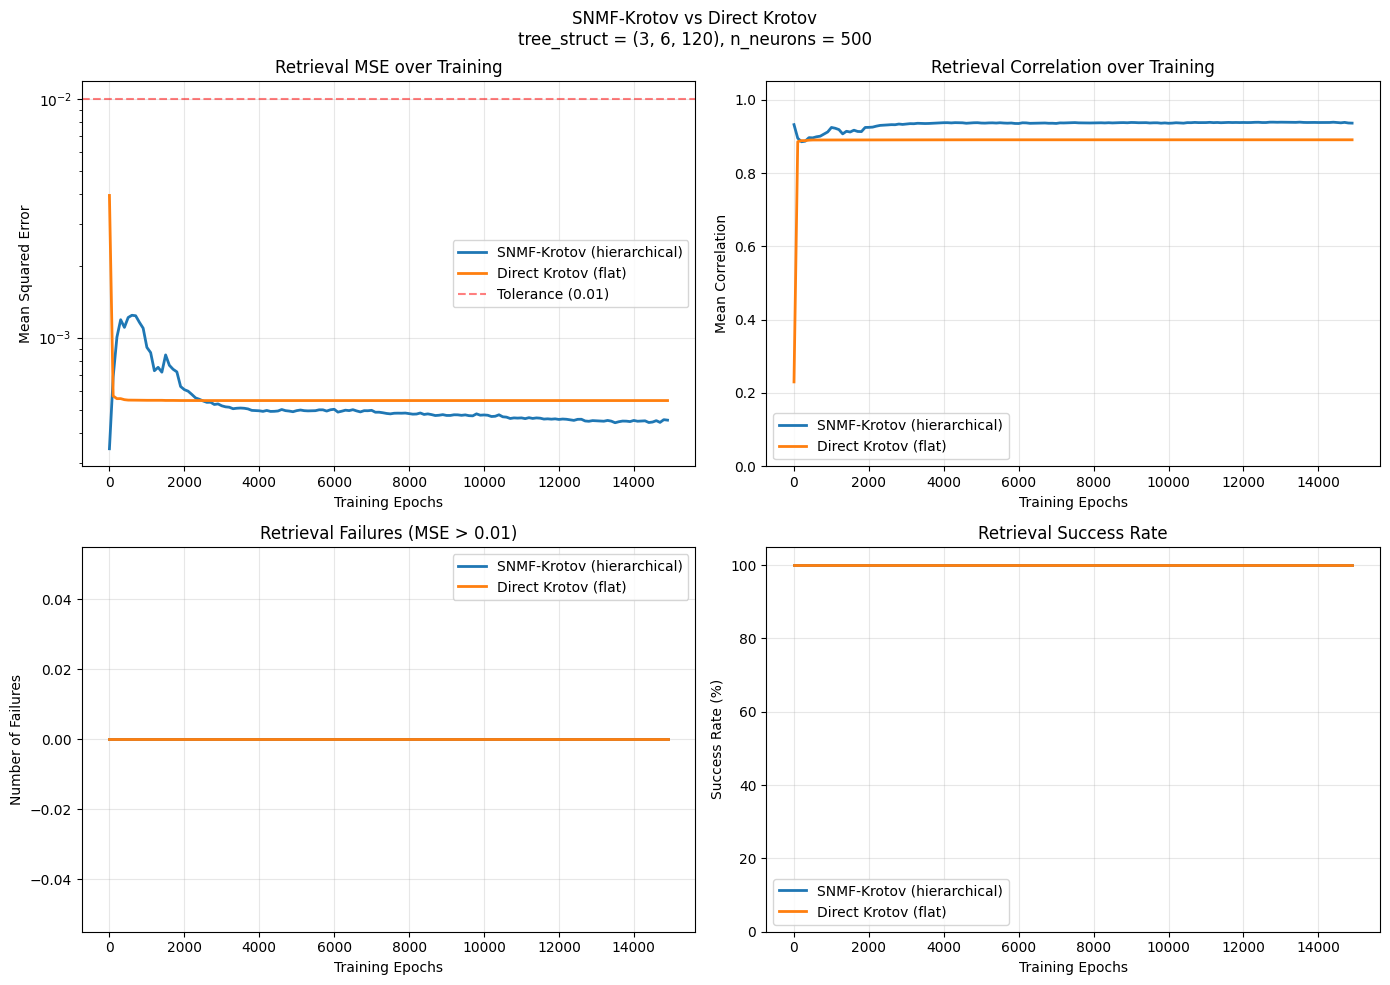

In [21]:
epochs_axis = np.arange(0, n_epochs, test_spacing)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MSE over training
ax1 = axes[0, 0]
ax1.plot(epochs_axis, mse_snmf, label='SNMF-Krotov (hierarchical)', linewidth=2)
ax1.plot(epochs_axis, mse_direct, label='Direct Krotov (flat)', linewidth=2)
ax1.axhline(y=mse_tolerance, color='r', linestyle='--', alpha=0.5, label=f'Tolerance ({mse_tolerance})')
ax1.set_xlabel('Training Epochs')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Retrieval MSE over Training')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Correlation over training
ax2 = axes[0, 1]
ax2.plot(epochs_axis, corr_snmf, label='SNMF-Krotov (hierarchical)', linewidth=2)
ax2.plot(epochs_axis, corr_direct, label='Direct Krotov (flat)', linewidth=2)
ax2.set_xlabel('Training Epochs')
ax2.set_ylabel('Mean Correlation')
ax2.set_title('Retrieval Correlation over Training')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1.05])

# Retrieval failures over training
ax3 = axes[1, 0]
ax3.plot(epochs_axis, failures_snmf, label='SNMF-Krotov (hierarchical)', linewidth=2)
ax3.plot(epochs_axis, failures_direct, label='Direct Krotov (flat)', linewidth=2)
ax3.set_xlabel('Training Epochs')
ax3.set_ylabel('Number of Failures')
ax3.set_title(f'Retrieval Failures (MSE > {mse_tolerance})')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Success rate over training
ax4 = axes[1, 1]
success_snmf = 1 - failures_snmf / n_patterns
success_direct = 1 - failures_direct / n_patterns
ax4.plot(epochs_axis, success_snmf * 100, label='SNMF-Krotov (hierarchical)', linewidth=2)
ax4.plot(epochs_axis, success_direct * 100, label='Direct Krotov (flat)', linewidth=2)
ax4.set_xlabel('Training Epochs')
ax4.set_ylabel('Success Rate (%)')
ax4.set_title('Retrieval Success Rate')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim([0, 105])

plt.suptitle(f'SNMF-Krotov vs Direct Krotov\ntree_struct = {tree_struct_list}, n_neurons = {n_input_neurons}', fontsize=12)
plt.tight_layout()
plt.show()

## 5. Final Evaluation

In [22]:
# Final comprehensive test
final_mse_snmf = []
final_mse_direct = []
final_corr_snmf = []
final_corr_direct = []

for j in range(n_patterns):
    x_test = all_patterns[j]
    
    y_snmf = network_snmf.retrieve(x_test, n_hopfield_iterations=10)
    y_direct = network_direct.retrieve(x_test, class_idx=0, n_iterations=10)
    
    final_mse_snmf.append(float(kh_snmf.compute_mse(x_test, y_snmf)))
    final_mse_direct.append(float(kh_direct.compute_mse(x_test, y_direct)))
    final_corr_snmf.append(float(kh_snmf.compute_correlation(x_test, y_snmf)))
    final_corr_direct.append(float(kh_direct.compute_correlation(x_test, y_direct)))

print("=" * 60)
print("FINAL EVALUATION (Clean Input Retrieval)")
print("=" * 60)

print(f"\nSNMF-Krotov Network (hierarchical):")
print(f"  Mean MSE: {np.mean(final_mse_snmf):.6f} +/- {np.std(final_mse_snmf):.6f}")
print(f"  Max MSE: {np.max(final_mse_snmf):.6f}")
print(f"  Mean Correlation: {np.mean(final_corr_snmf):.4f} +/- {np.std(final_corr_snmf):.4f}")
print(f"  Min Correlation: {np.min(final_corr_snmf):.4f}")
print(f"  Failures (MSE > {mse_tolerance}): {np.sum(np.array(final_mse_snmf) > mse_tolerance)}")

print(f"\nDirect Krotov Network (flat):")
print(f"  Mean MSE: {np.mean(final_mse_direct):.6f} +/- {np.std(final_mse_direct):.6f}")
print(f"  Max MSE: {np.max(final_mse_direct):.6f}")
print(f"  Mean Correlation: {np.mean(final_corr_direct):.4f} +/- {np.std(final_corr_direct):.4f}")
print(f"  Min Correlation: {np.min(final_corr_direct):.4f}")
print(f"  Failures (MSE > {mse_tolerance}): {np.sum(np.array(final_mse_direct) > mse_tolerance)}")

print(f"\nComparison:")
mse_ratio = np.mean(final_mse_direct) / np.mean(final_mse_snmf)
print(f"  MSE Ratio (Direct/SNMF): {mse_ratio:.2f}x")
print(f"  (< 1 means Direct is better, > 1 means SNMF is better)")

FINAL EVALUATION (Clean Input Retrieval)

SNMF-Krotov Network (hierarchical):
  Mean MSE: 0.000453 +/- 0.000322
  Max MSE: 0.002103
  Mean Correlation: 0.9364 +/- 0.0486
  Min Correlation: 0.5798
  Failures (MSE > 0.01): 0

Direct Krotov Network (flat):
  Mean MSE: 0.000545 +/- 0.000038
  Max MSE: 0.000658
  Mean Correlation: 0.8907 +/- 0.0101
  Min Correlation: 0.8640
  Failures (MSE > 0.01): 0

Comparison:
  MSE Ratio (Direct/SNMF): 1.20x
  (< 1 means Direct is better, > 1 means SNMF is better)


## 6. Noise Robustness Test

In [23]:
# Test retrieval with noisy inputs
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.5, 0.7]
key = jax.random.PRNGKey(123)

results_snmf = {}
results_direct = {}

for noise_std in noise_levels:
    mse_list_snmf = []
    mse_list_direct = []
    corr_list_snmf = []
    corr_list_direct = []
    
    for j in range(n_patterns):
        key, subkey = jax.random.split(key)
        x = all_patterns[j]
        
        # Add noise
        if noise_std > 0:
            x_noisy = np.array(kh_snmf.add_gaussian_noise(x, subkey, noise_std))
        else:
            x_noisy = x
        
        # Retrieve with SNMF-Krotov
        y_snmf = network_snmf.retrieve(x_noisy, n_hopfield_iterations=10)
        mse_list_snmf.append(float(kh_snmf.compute_mse(x, y_snmf)))  # Compare to original
        corr_list_snmf.append(float(kh_snmf.compute_correlation(x, y_snmf)))
        
        # Retrieve with Direct Krotov
        y_direct = network_direct.retrieve(x_noisy, class_idx=0, n_iterations=10)
        mse_list_direct.append(float(kh_direct.compute_mse(x, y_direct)))  # Compare to original
        corr_list_direct.append(float(kh_direct.compute_correlation(x, y_direct)))
    
    results_snmf[noise_std] = {
        'mean_mse': np.mean(mse_list_snmf),
        'mean_corr': np.mean(corr_list_snmf),
        'failures': np.sum(np.array(mse_list_snmf) > mse_tolerance)
    }
    results_direct[noise_std] = {
        'mean_mse': np.mean(mse_list_direct),
        'mean_corr': np.mean(corr_list_direct),
        'failures': np.sum(np.array(mse_list_direct) > mse_tolerance)
    }

# Display results
print("Noise Robustness Comparison")
print("=" * 80)
print(f"{'Noise':<8} {'SNMF MSE':<12} {'Direct MSE':<12} {'SNMF Corr':<12} {'Direct Corr':<12} {'SNMF Fail':<10} {'Direct Fail':<10}")
print("-" * 80)
for noise in noise_levels:
    rs = results_snmf[noise]
    rd = results_direct[noise]
    print(f"{noise:<8.2f} {rs['mean_mse']:<12.6f} {rd['mean_mse']:<12.6f} {rs['mean_corr']:<12.4f} {rd['mean_corr']:<12.4f} {rs['failures']:<10} {rd['failures']:<10}")

/Users/fitzgeraldsnow/Desktop/Neural Science/modular network/RotationBennaLab-master/krotov_hopfield_no_init.py:55: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  y = optimize.fsolve(fun, w_mul_x)


Noise Robustness Comparison
Noise    SNMF MSE     Direct MSE   SNMF Corr    Direct Corr  SNMF Fail  Direct Fail
--------------------------------------------------------------------------------
0.00     0.000453     0.000545     0.9364       0.8907       0          0         
0.10     0.000543     0.000545     0.9204       0.8907       0          0         
0.20     0.000721     0.000545     0.8894       0.8907       0          0         
0.30     0.000981     0.000589     0.8444       0.8813       0          0         
0.50     0.001776     0.001093     0.7112       0.7734       0          0         
0.70     0.002474     0.001629     0.5967       0.6589       0          0         


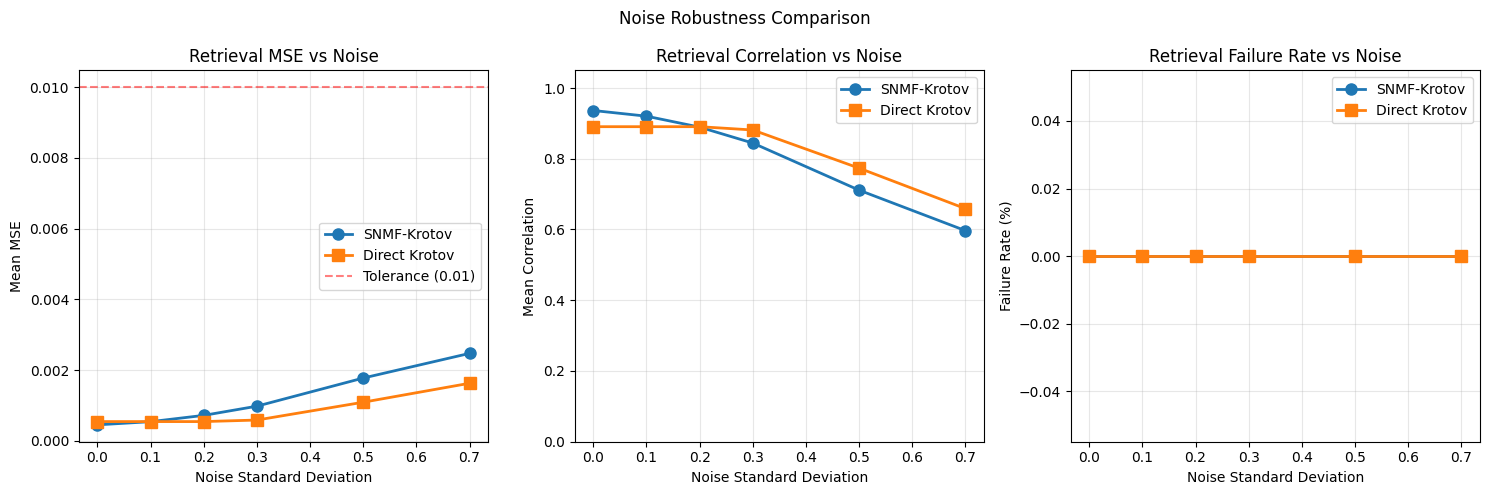

In [24]:
# Visualize noise robustness
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MSE vs noise
ax1 = axes[0]
mse_snmf_noise = [results_snmf[n]['mean_mse'] for n in noise_levels]
mse_direct_noise = [results_direct[n]['mean_mse'] for n in noise_levels]
ax1.plot(noise_levels, mse_snmf_noise, 'o-', markersize=8, label='SNMF-Krotov', linewidth=2)
ax1.plot(noise_levels, mse_direct_noise, 's-', markersize=8, label='Direct Krotov', linewidth=2)
ax1.axhline(y=mse_tolerance, color='r', linestyle='--', alpha=0.5, label=f'Tolerance ({mse_tolerance})')
ax1.set_xlabel('Noise Standard Deviation')
ax1.set_ylabel('Mean MSE')
ax1.set_title('Retrieval MSE vs Noise')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Correlation vs noise
ax2 = axes[1]
corr_snmf_noise = [results_snmf[n]['mean_corr'] for n in noise_levels]
corr_direct_noise = [results_direct[n]['mean_corr'] for n in noise_levels]
ax2.plot(noise_levels, corr_snmf_noise, 'o-', markersize=8, label='SNMF-Krotov', linewidth=2)
ax2.plot(noise_levels, corr_direct_noise, 's-', markersize=8, label='Direct Krotov', linewidth=2)
ax2.set_xlabel('Noise Standard Deviation')
ax2.set_ylabel('Mean Correlation')
ax2.set_title('Retrieval Correlation vs Noise')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1.05])

# Failure rate vs noise
ax3 = axes[2]
fail_snmf_noise = [results_snmf[n]['failures'] / n_patterns * 100 for n in noise_levels]
fail_direct_noise = [results_direct[n]['failures'] / n_patterns * 100 for n in noise_levels]
ax3.plot(noise_levels, fail_snmf_noise, 'o-', markersize=8, label='SNMF-Krotov', linewidth=2)
ax3.plot(noise_levels, fail_direct_noise, 's-', markersize=8, label='Direct Krotov', linewidth=2)
ax3.set_xlabel('Noise Standard Deviation')
ax3.set_ylabel('Failure Rate (%)')
ax3.set_title('Retrieval Failure Rate vs Noise')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.suptitle('Noise Robustness Comparison', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Visualization: Retrieved vs Original Patterns

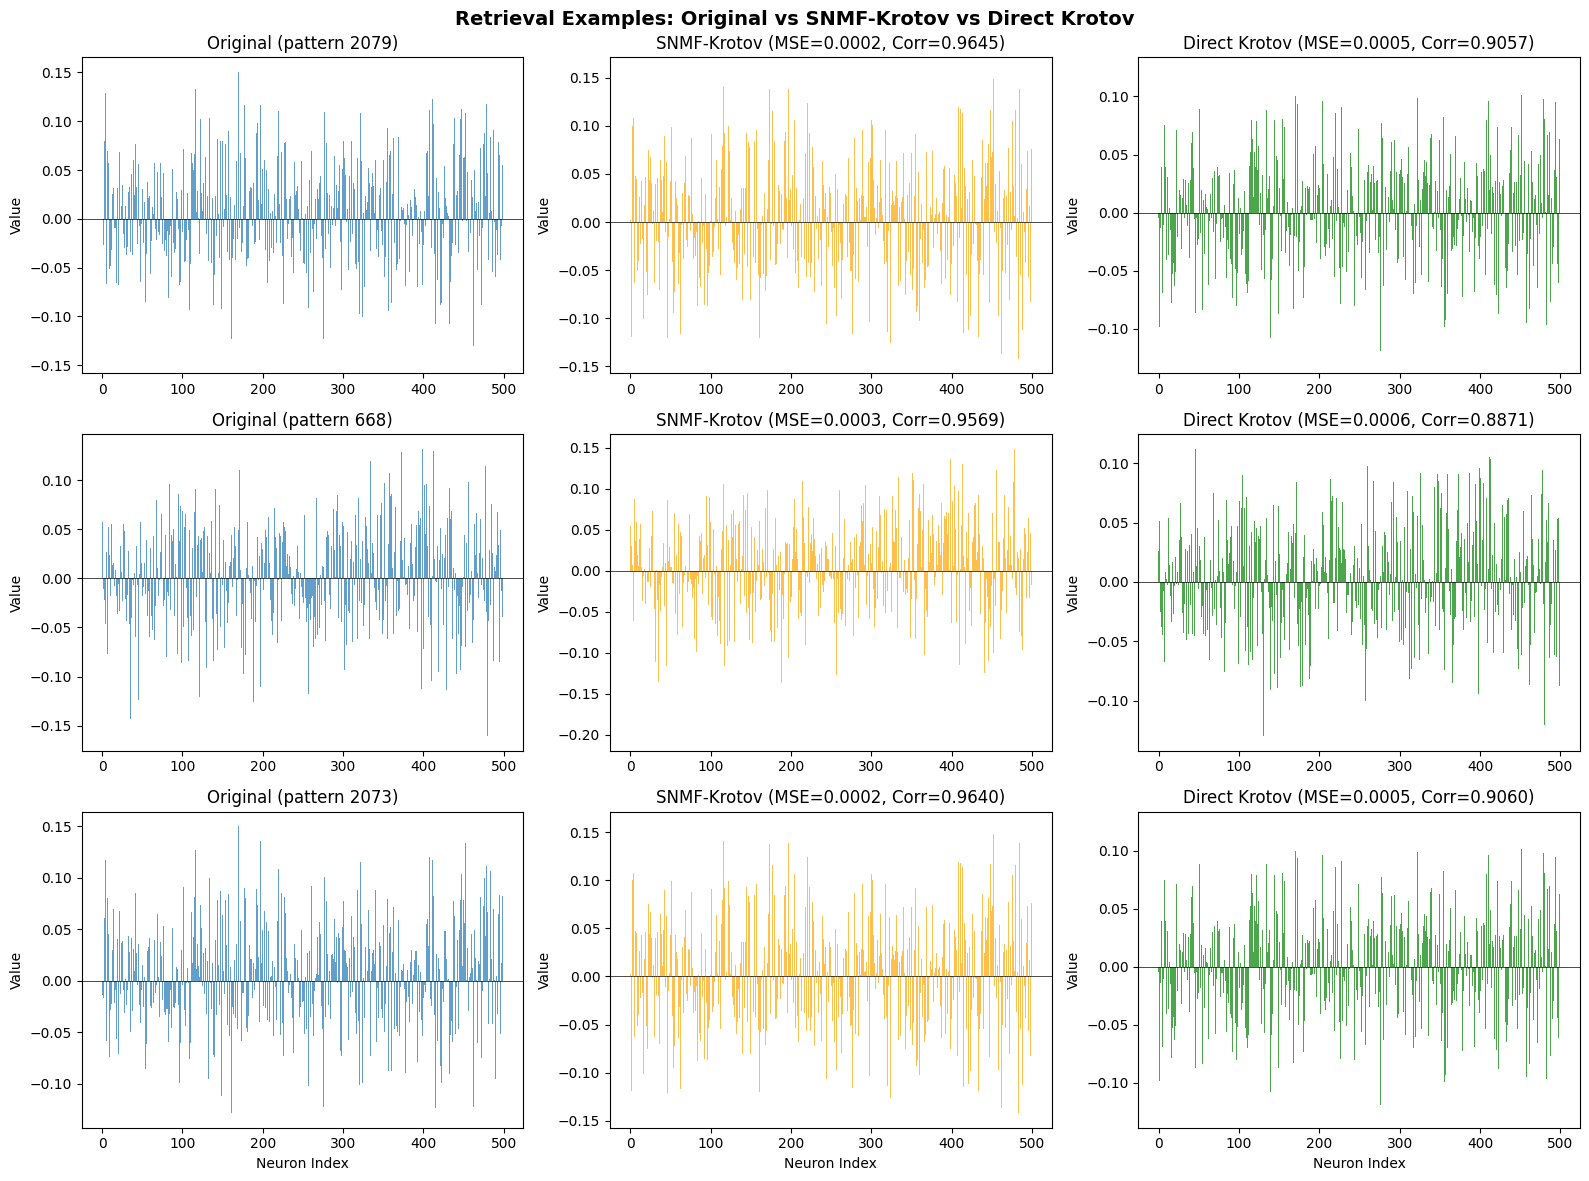

In [25]:
# Visualize retrieval examples for both networks
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

# Select 3 random patterns
np.random.seed(42)
sample_indices = np.random.choice(n_patterns, 3, replace=False)

for row, idx in enumerate(sample_indices):
    x = all_patterns[idx]
    y_snmf = network_snmf.retrieve(x, n_hopfield_iterations=10)
    y_direct = network_direct.retrieve(x, class_idx=0, n_iterations=10)
    
    mse_s = kh_snmf.compute_mse(x, y_snmf)
    mse_d = kh_direct.compute_mse(x, y_direct)
    corr_s = kh_snmf.compute_correlation(x, y_snmf)
    corr_d = kh_direct.compute_correlation(x, y_direct)
    
    # Original
    axes[row, 0].bar(range(n_input_neurons), x, width=1.0, alpha=0.7)
    axes[row, 0].set_title(f'Original (pattern {idx})')
    axes[row, 0].set_ylabel('Value')
    axes[row, 0].axhline(y=0, color='k', linewidth=0.5)
    
    # SNMF-Krotov retrieved
    axes[row, 1].bar(range(n_input_neurons), y_snmf, width=1.0, alpha=0.7, color='orange')
    axes[row, 1].set_title(f'SNMF-Krotov (MSE={mse_s:.4f}, Corr={corr_s:.4f})')
    axes[row, 1].set_ylabel('Value')
    axes[row, 1].axhline(y=0, color='k', linewidth=0.5)
    
    # Direct Krotov retrieved
    axes[row, 2].bar(range(n_input_neurons), y_direct, width=1.0, alpha=0.7, color='green')
    axes[row, 2].set_title(f'Direct Krotov (MSE={mse_d:.4f}, Corr={corr_d:.4f})')
    axes[row, 2].set_ylabel('Value')
    axes[row, 2].axhline(y=0, color='k', linewidth=0.5)

axes[2, 0].set_xlabel('Neuron Index')
axes[2, 1].set_xlabel('Neuron Index')
axes[2, 2].set_xlabel('Neuron Index')
plt.suptitle('Retrieval Examples: Original vs SNMF-Krotov vs Direct Krotov', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Capacity Analysis

Test how performance scales with the number of stored patterns.

In [26]:
# Test capacity by gradually increasing the number of stored patterns
pattern_counts = [50, 100, 150, 200, 250, 300, 360]

capacity_mse_snmf = []
capacity_mse_direct = []
capacity_corr_snmf = []
capacity_corr_direct = []

for n_store in tqdm(pattern_counts, desc="Testing capacity"):
    # Create fresh networks
    np.random.seed(456)
    net_snmf = kh_snmf.TreeNetworkKrotovNoInit(
        n_input_neurons=n_input_neurons,
        tree_struct_list=tree_struct_list[:-1],
        tree_decay1_list=(0.99, 0.99),
        tree_decay2_list=(0.99, 0.99),
        decay3=0.99,
        beta=beta,
        max_patterns=100
    )
    
    np.random.seed(456)
    net_direct = kh_direct.DirectKrotovNetwork(
        n_neurons=n_input_neurons,
        n_classes=1,
        beta=beta,
        decay=0.99,
        max_patterns_per_class=400
    )
    
    # Train on subset of patterns
    patterns_subset = all_patterns[:n_store]
    n_train_epochs = n_store * 30  # 30 presentations per pattern on average
    
    for _ in range(n_train_epochs):
        idx = np.random.randint(n_store)
        net_snmf.update_weights(patterns_subset[idx])
        net_direct.store(patterns_subset[idx], class_idx=0)
    
    # Evaluate
    mse_s = []
    mse_d = []
    corr_s = []
    corr_d = []
    
    for j in range(n_store):
        x = patterns_subset[j]
        y_s = net_snmf.retrieve(x, n_hopfield_iterations=10)
        y_d = net_direct.retrieve(x, class_idx=0, n_iterations=10)
        
        mse_s.append(float(kh_snmf.compute_mse(x, y_s)))
        mse_d.append(float(kh_direct.compute_mse(x, y_d)))
        corr_s.append(float(kh_snmf.compute_correlation(x, y_s)))
        corr_d.append(float(kh_direct.compute_correlation(x, y_d)))
    
    capacity_mse_snmf.append(np.mean(mse_s))
    capacity_mse_direct.append(np.mean(mse_d))
    capacity_corr_snmf.append(np.mean(corr_s))
    capacity_corr_direct.append(np.mean(corr_d))

Testing capacity: 100%|██████████| 7/7 [00:15<00:00,  2.15s/it]


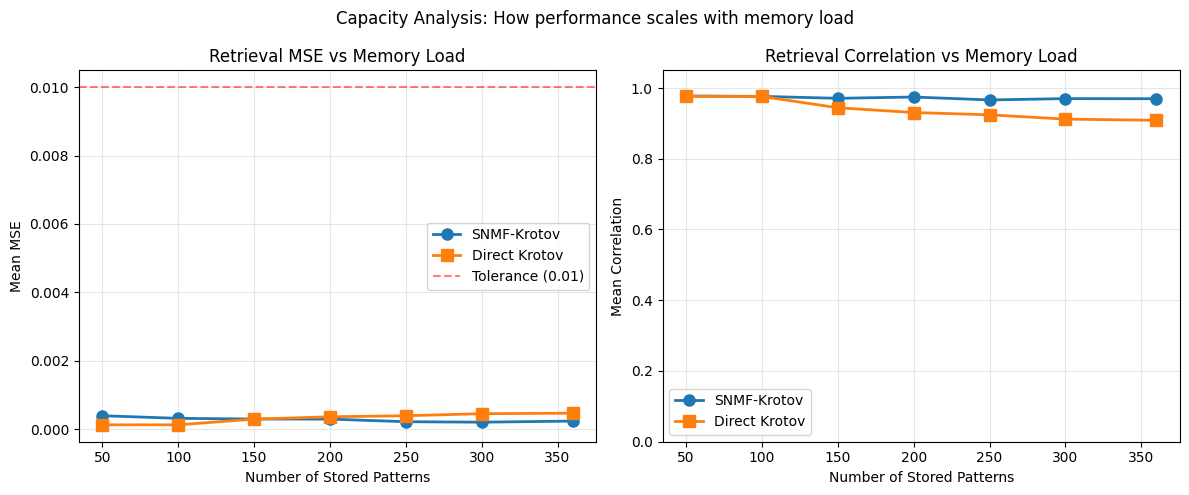

In [27]:
# Visualize capacity analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MSE vs pattern count
ax1 = axes[0]
ax1.plot(pattern_counts, capacity_mse_snmf, 'o-', markersize=8, label='SNMF-Krotov', linewidth=2)
ax1.plot(pattern_counts, capacity_mse_direct, 's-', markersize=8, label='Direct Krotov', linewidth=2)
ax1.axhline(y=mse_tolerance, color='r', linestyle='--', alpha=0.5, label=f'Tolerance ({mse_tolerance})')
ax1.set_xlabel('Number of Stored Patterns')
ax1.set_ylabel('Mean MSE')
ax1.set_title('Retrieval MSE vs Memory Load')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Correlation vs pattern count
ax2 = axes[1]
ax2.plot(pattern_counts, capacity_corr_snmf, 'o-', markersize=8, label='SNMF-Krotov', linewidth=2)
ax2.plot(pattern_counts, capacity_corr_direct, 's-', markersize=8, label='Direct Krotov', linewidth=2)
ax2.set_xlabel('Number of Stored Patterns')
ax2.set_ylabel('Mean Correlation')
ax2.set_title('Retrieval Correlation vs Memory Load')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1.05])

plt.suptitle('Capacity Analysis: How performance scales with memory load', fontsize=12)
plt.tight_layout()
plt.show()

## 9. Summary

In [28]:
print("=" * 70)
print("COMPARISON SUMMARY: SNMF-Krotov vs Direct Krotov")
print("=" * 70)

print(f"\nConfiguration:")
print(f"  Pattern dimension: {n_input_neurons}")
print(f"  Total patterns: {n_patterns}")
print(f"  Tree structure: {tree_struct_list}")
print(f"  Training epochs: {n_epochs}")
print(f"  Beta (inverse temperature): {beta}")

print(f"\nFinal Performance (Clean Input):")
print(f"  SNMF-Krotov:")
print(f"    MSE: {np.mean(final_mse_snmf):.6f}")
print(f"    Correlation: {np.mean(final_corr_snmf):.4f}")
print(f"  Direct Krotov:")
print(f"    MSE: {np.mean(final_mse_direct):.6f}")
print(f"    Correlation: {np.mean(final_corr_direct):.4f}")

print(f"\nNoise Robustness (sigma=0.3):")
print(f"  SNMF-Krotov:")
print(f"    MSE: {results_snmf[0.3]['mean_mse']:.6f}")
print(f"    Correlation: {results_snmf[0.3]['mean_corr']:.4f}")
print(f"    Failures: {results_snmf[0.3]['failures']}/{n_patterns}")
print(f"  Direct Krotov:")
print(f"    MSE: {results_direct[0.3]['mean_mse']:.6f}")
print(f"    Correlation: {results_direct[0.3]['mean_corr']:.4f}")
print(f"    Failures: {results_direct[0.3]['failures']}/{n_patterns}")

print("\n" + "=" * 70)
print("CONCLUSION")
print("=" * 70)

mse_ratio = np.mean(final_mse_direct) / np.mean(final_mse_snmf)
noise_ratio = results_direct[0.3]['mean_mse'] / results_snmf[0.3]['mean_mse']

if mse_ratio < 0.9:
    print("\nDirect Krotov performs BETTER (lower MSE)")
    print("  -> For flat pattern sets, skip SNMF clustering")
elif mse_ratio > 1.1:
    print("\nSNMF-Krotov performs BETTER (lower MSE)")
    print("  -> Hierarchical clustering helps with ultrametric patterns")
else:
    print("\nPerformance is COMPARABLE (MSE ratio ~ 1.0)")
    print("  -> Choice depends on other factors (interpretability, scalability)")

if noise_ratio < 0.9:
    print("  -> Direct Krotov is more noise robust")
elif noise_ratio > 1.1:
    print("  -> SNMF-Krotov is more noise robust")

print("\nNote: SNMF provides interpretable clustering structure,")
print("while Direct Krotov is simpler and may scale better for flat datasets.")
print("=" * 70)

COMPARISON SUMMARY: SNMF-Krotov vs Direct Krotov

Configuration:
  Pattern dimension: 500
  Total patterns: 2160
  Tree structure: (3, 6, 120)
  Training epochs: 15000
  Beta (inverse temperature): 5.0

Final Performance (Clean Input):
  SNMF-Krotov:
    MSE: 0.000453
    Correlation: 0.9364
  Direct Krotov:
    MSE: 0.000545
    Correlation: 0.8907

Noise Robustness (sigma=0.3):
  SNMF-Krotov:
    MSE: 0.000981
    Correlation: 0.8444
    Failures: 0/2160
  Direct Krotov:
    MSE: 0.000589
    Correlation: 0.8813
    Failures: 0/2160

CONCLUSION

SNMF-Krotov performs BETTER (lower MSE)
  -> Hierarchical clustering helps with ultrametric patterns
  -> Direct Krotov is more noise robust

Note: SNMF provides interpretable clustering structure,
while Direct Krotov is simpler and may scale better for flat datasets.
